Data Science + Social Justice<br>
Distant Reading <br>
Created by Tom van Nuenen (tom.van_nuenen@kcl.ac.uk)

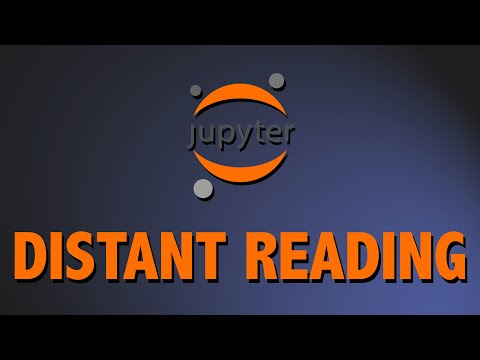

In [1]:
# Please run this cell for the accompanying video.
from IPython.display import YouTubeVideo
YouTubeVideo('fW7jEn4gEqQ', width=640, height=360)

# Distant reading 

This notebook introduces some methods to engage in a simple distant reading using NLTK. We'll keep builing on our AITA DataFrame, discussing some simple ways to explore data. 

**After completing this notebook, you will be able to:**
1. Do some more data operations in Pandas;
2. Use NLTK's `Text()` object to perform some basic distant reading operations on a subreddit;

There are several basic programming exercises scattered throughout for those who need it.


## Retrieving the dataset
Let's get the data. Make sure you're in the "Data" directory when importing by running the magic command `%pwd`.
If you're not in the right directory, use `os.chdir` to navigate there.

In [1]:
%pwd

'/Users/tomvannuenen/Downloads/DIGHUM160/Notebooks/Week 2'

In [2]:
import os
# We include two ../ because we want to go two levels up in the file structure
os.chdir('../../Data')

Importing 

In [5]:
import pandas as pd

df = pd.read_csv('aita_sub_top_sm_lemmas.csv')

# 1. A couple more Pandas operations

Let's have a look at the data

In [4]:
df.head(3)

,idint,idstr,created,nsfw,author,title,selftext,lemmas,score,distinguish,textlen,num_comments,flair_text,flair_css_class
0,427576402,t3_72kg2a,1506433689,0.0,Ritsku,AITA for breaking up with my girlfriend becaus...,My girlfriend recently went to the beach with ...,girlfriend recently beach friend tiny bikini b...,679.0,NaN,4917.0,434.0,no a--holes here,NaN
1,551887974,t3_94kvhi,1533404095,0.0,hhhhhhffff678,AITA for banning smoking in my house and telli...,My parents smoke like chimneys. I used to as w...,parent smoke like chimney use quit wife young ...,832.0,NaN,2076.0,357.0,asshole,ass
2,552654542,t3_951az2,1533562299,0.0,creepatthepool,AITA? Creep wears skimpy bathing suit to pool,Hi guys. Throwaway for obv reasons.\n\nI'm a f...,hi guy throwaway obv reason i'm female child b...,23.0,NaN,1741.0,335.0,Shitpost,NaN


### Sorting a DF
Using the `.sort_values()` method we can sort the df by particular columms. We use two parameters: the `by` parameter indicates by which column we want to sort, the `ascending` parameter indicated whether our sortation is in ascending or descending order.

In [163]:
df.sort_values(by=['score'], ascending=False)[:3]

,idint,idstr,created,nsfw,author,title,selftext,lemmas,score,distinguish,textlen,num_comments,flair_text,flair_css_class
2635,797709732,t3_d6xoro,1568998300,0.0,DarthCharizard,META: This sub is moving towards a value syste...,I’ve enjoyed reading and posting on this sub f...,enjoy read post sub month feel like notice dis...,80915.0,NaN,9.0,6215.0,META,NaN
12793,1472895100,t3_ocx94s,1625315782,0.0,OnlyInQuebec9,AITA for telling my wife the lock on my daught...,My brother in-law (Sammy) lost his home shortl...,brother law sammy lose home shortly divorce mo...,80334.0,NaN,2664.0,5318.0,Not the A-hole,not
398,664921441,t3_azvko1,1552322462,0.0,Renegadesrule33,"UPDATE, AITA for despising my mentally handica...","I'm back like I said I would be,. My [original...",like original_post](https://www.reddit.com_r_a...,72776.0,NaN,9.0,1989.0,UPDATE,NaN


One thing we often do when we’re exploring a dataset is filtering the data based on a given condition. For example, we might need to find all the rows in our dataset where the score is over 500. We can use the `.loc[]` method to do so.

`.loc[]` is a powerful method that can be used for all kinds of research purposes, if you want to filter or prune your dataset based on some condition. For more info, see [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html).

For instance, if we only want rows with a score higher than 500:

In [164]:
df_top = df.loc[df.score >= 500]
len(df_top)

15609

Note that we could also just access this data using `df[df.score >= 500]` (without the `.loc`). This is a bit shorter but has some drawbacks. See [this post](https://stackoverflow.com/questions/38886080/python-pandas-series-why-use-loc) for more info.

### Converting to datetime
Did you ever wonder which format the "created" column is in? It is a Unix timestamp: the number of seconds that have elapsed since the Unix epoch, minus leap seconds; the Unix epoch is 00:00:00 UTC on 1 January 1970.

In [165]:
pd.to_datetime(1207632114,unit='s')

Timestamp('2008-04-08 05:21:54')

Pandas allows us to create a new column evaluating the Unix timestamp to more readable datetimes using the `.to_datetime` method. 

Creating a new column in Pandas is as easy as using the bracket notation to write a new column name, then assigning it. In this case, we just use the `.to_datetime` method again to point to the entire "created" column.

In [7]:
df.insert(loc=3, column='created_datetime', value=pd.to_datetime(df['created'],unit='s'))
df.head(3)

,idint,idstr,created,created_datetime,nsfw,author,title,selftext,lemmas,score,distinguish,textlen,num_comments,flair_text,flair_css_class
0,427576402,t3_72kg2a,1506433689,2017-09-26 13:48:09,0.0,Ritsku,AITA for breaking up with my girlfriend becaus...,My girlfriend recently went to the beach with ...,girlfriend recently beach friend tiny bikini b...,679.0,NaN,4917.0,434.0,no a--holes here,NaN
1,551887974,t3_94kvhi,1533404095,2018-08-04 17:34:55,0.0,hhhhhhffff678,AITA for banning smoking in my house and telli...,My parents smoke like chimneys. I used to as w...,parent smoke like chimney use quit wife young ...,832.0,NaN,2076.0,357.0,asshole,ass
2,552654542,t3_951az2,1533562299,2018-08-06 13:31:39,0.0,creepatthepool,AITA? Creep wears skimpy bathing suit to pool,Hi guys. Throwaway for obv reasons.\n\nI'm a f...,hi guy throwaway obv reason i'm female child b...,23.0,NaN,1741.0,335.0,Shitpost,NaN


Let's save this new DF again.

In [167]:
df.to_csv('aita_sub_top_sm_lemmas.csv', index=False)

Our new "created_datetime" column is in a datetime format that Pandas can work with. We do so by calling the `DateTimeIndex` method: when we access the data in this column (also called a Series), the `DateTimeIndex` method turns it into a so-called Time Series. This is data type that allows for specific functionalities. For instance, we can check which years our Time Series data contains. 

In [168]:
from collections import Counter

pd.DatetimeIndex(df['created_datetime']).year.value_counts()

2021    6375
2020    6118
2019    3698
2018     118
2017       1
Name: created_datetime, dtype: int64

Looks like most of our data was written in 2021. 

## Checking value counts
We can also look at unique value counts for a column by running `value_counts()`, or easily visualize those counts using `hist()`.

Let's have a look at two particularly interesting columns: "flair_text" and "flair_css_class*. A flair, in Reddit, allows users to tag posts or usernames in certain subreddits to add context or humor. Here, the flair attached to the posts are created by moderators after the community votes on whether an OP was or wasn't the asshole. There are also other flairs such as "No assholes here" or "Everyone sucks". See [here](https://www.reddit.com/r/AmItheAsshole/wiki/faq) for more information.

This community-driven data segmentation is quite helpful for us!

In [75]:
df.flair_text.value_counts()

Not the A-hole        41749
Asshole               18115
No A-holes here        3665
Everyone Sucks         2981
Not enough info         931
                      ...  
communicate               1
asshole soceity           1
Call for help :(          1
not the speed pass        1
Eat Stew Homie            1
Name: flair_text, Length: 97, dtype: int64

<AxesSubplot:>

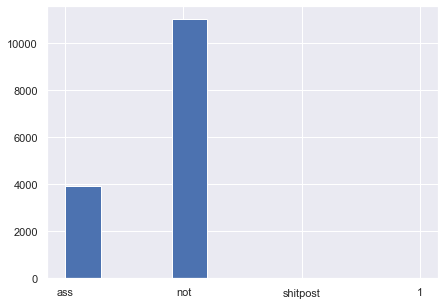

In [123]:
df.flair_css_class.hist()

Let's see if we can find out whether people are considered assholes more frequently in particular months. 
We'll first create a new DF with just the submissions from 2021.

In [8]:
df_2021 = df[pd.DatetimeIndex(df['created_datetime']).year == 2021]
len(df_2021)

6375

Using the `month_name()` method of `DateTimeIndex`, we can see which month each post was written in:



In [170]:
months_array = pd.DatetimeIndex(df_2021['created_datetime']).month_name()
months_array

Index(['January', 'January', 'January', 'January', 'January', 'January',
       'January', 'January', 'January', 'January',
       ...
       'December', 'December', 'December', 'December', 'December', 'December',
       'December', 'December', 'December', 'December'],
      dtype='object', name='created_datetime', length=6375)

Now we have all we need to visualize the data. We will use the seaborn library to plot `df_2021`, using the `Datetimeindex` array we just created to separate counts on the x-axis.

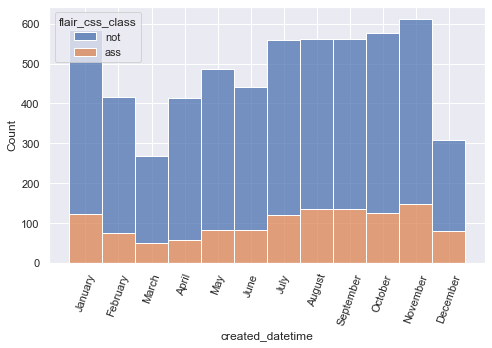

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

sns.set(rc={'figure.figsize':(7,5)})

p = sns.histplot(
    data=df_2021, 
    x=months_array,
    hue="flair_css_class",
    multiple="stack"
)

plt.xticks(rotation=70)
plt.tight_layout()

## Calculating Type-token ratio
Next, let's figure out the type-token ratio for our posts. Type-token ratio is a crude algorithm to gauge language complexity. First, we'll create a function that computes the TTR.

In [125]:
def typeTokenRatio(tokens): 
    numTokens = len(tokens)
    numTypes = len(set(tokens))
    return numTypes/numTokens

Finally, we loop over the first 10 lemmatized submissions in our df.

In [126]:
for x in df_2021['selftext'][:10]:
    t = x.split()
    print(typeTokenRatio(t))

0.5747422680412371
0.625
0.4836879432624113
0.5726495726495726
0.5642458100558659
0.4875239923224568
0.6185567010309279
0.488
0.5084269662921348
0.5114503816793893


### Distant reading with NLTK `Text()`
Let's have another look at our data. NLTK provides a `Text()` class, which is a "wrapper" that allows for inital exploration of texts. It supports counting, concordancing, collocation discovery, etc. 

Let's use our "lemmas" data we created in the last notebook. All we need to do is run `split()` on it to get our tokens.

In [28]:
total = []
for row in df_2021['lemmas']:
    total.extend(row.split(' '))

In [29]:
len(total)

960896

In [17]:
import nltk
from nltk.text import Text
nltk.download('stopwords')

aita_t = Text(total)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tomvannuenen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's print out the "docstring" of NLTK's `Text()` object, as well as all the things you can do with this object. Have a read through this to see what it allows you to do!

In [18]:
help(Text)

Help on class Text in module nltk.text:

class Text(builtins.object)
 |  Text(tokens, name=None)
 |  
 |  A wrapper around a sequence of simple (string) tokens, which is
 |  intended to support initial exploration of texts (via the
 |  interactive console).  Its methods perform a variety of analyses
 |  on the text's contexts (e.g., counting, concordancing, collocation
 |  discovery), and display the results.  If you wish to write a
 |  program which makes use of these analyses, then you should bypass
 |  the ``Text`` class, and use the appropriate analysis function or
 |  class directly instead.
 |  
 |  A ``Text`` is typically initialized from a given document or
 |  corpus.  E.g.:
 |  
 |  >>> import nltk.corpus
 |  >>> from nltk.text import Text
 |  >>> moby = Text(nltk.corpus.gutenberg.words('melville-moby_dick.txt'))
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, i)
 |  
 |  __init__(self, tokens, name=None)
 |      Create a Text object.
 |      
 |      :param tokens:

### Concordances 
One of the most basic, but quite helpful, ways to quickly get an overview of the contexts in which a word appears is through a concordance view. 

In [19]:
aita_t.concordance('mistake', width=115)

Displaying 25 of 279 matches:
ve damage kid mentally aita include kids??*edit leave mistake daughter car 16th_birthday cause issue ex current hus
?!”)aita ask flush tampon throwaway privacy apologize mistake english main language i(f26 work hr hire people posit
mbarrass bs want know asshole ish try brief apologize mistake english i've raise niece hannah year old biological m
 cigar weed like chimney miracle baby tactic work try mistake love forgive care kid tactic suffice mark kick fully 
ight blow final edit think):i imagine post 1k comment mistake end tell stacie real job especially table colleague m
er employee access camera sit threaten fire pay prove mistake try accuse steal product absolutely absurd proof plus
sur sha).most people meet school sur sha correct fact mistake pretty embarrassing encounter irish girl class laugh 
g day worry weird cat aita shower cat room?also sorry mistake post english second language.[update]hi thank comment
report office manager mansplaine office ma

### Collocations
A collocation is a sequence of words that often appear together. The .collocations() method can find these in our data.


In [87]:
aita_t.collocations()

feel like; even though; years ago; year old; social media; high
school; big deal; Fast forward; take care; months ago; mental health;
days ago; feel bad; living room; story short; passed away; last year;
Long story; passive aggressive; best friend


### Word plotting
Using the `dispersion_plot()` method we can easily visualize how often some word appears throughout the text. We have to feed it a list with several words.

If our df is sorted by date we can see "through time" to see whether particular words start (dis)appearing in our data.

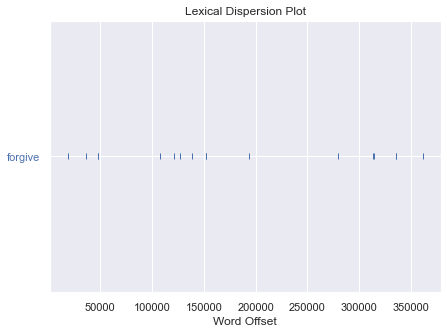

In [88]:
aita_t.dispersion_plot(["forgive"])

### Similar words
Using the `.similar()` method we can look at "distributional similarity": finding other words which appear in the same contexts as the specified word.
 

In [89]:
aita_t.similar('girlfriend')

mom wife family dad parents sister husband brother mother friend
daughter son friends father dog house gf boyfriend room job


### Common context
The `.common_contexts()` method allows us to study the common context of two or more words. We must enclose these words in square brackets and round brackets, separated by commas. 

In [90]:
aita_t.common_contexts(['mom', 'dad'])

my_and my_is my_was my_told my_said my_has my_to my_i my_she my_for
her_and his_and her_is my_that my_asked my_did my_because my_but
my_when my_does
